In [28]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

### Libs

In [124]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# plot the regression fit for comparison
def plot_fit(feature, target, slope, intercept):
    plt.scatter(feature, target,  color='blue')
    xi = np.arange(0.0, 1.0, 0.1)
    line = slope * xi + intercept
    plt.plot(xi, line[0])
    return plt

### Data

In [125]:
# we fake some events with good correlation
N_EVENTS = 100
feature = np.random.rand(N_EVENTS)
target = feature + np.random.rand(N_EVENTS)*0.2
df = pd.DataFrame(data = zip(feature, target), columns=['feature', 'target'])
df.head(3)

,feature,target
0,0.106494,0.132724
1,0.340381,0.494993
2,0.653674,0.768152


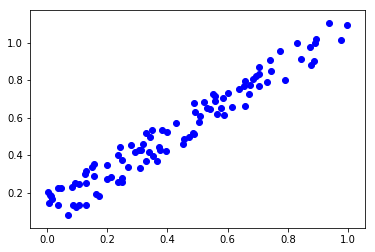

In [126]:
plt.scatter(feature, target, color='blue')
plt.show()

### Prepare Data for Tensor Flow

In [127]:
m = N_EVENTS
n = 1 # one feature

data_plus_bias = np.c_[np.ones((m, 1)), feature]
X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(target.reshape(-1, 1), dtype=tf.float32, name="y")

### => regression with scikit (for comparisons)

In [128]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(np.c_[feature], target)
intercept = lin_reg.intercept_.reshape(-1, 1)
slope = lin_reg.coef_.T
print "intercept: ", intercept
print "coefficients: ", slope

intercept:  [[ 0.11592658]]
coefficients:  [ 0.96855849]


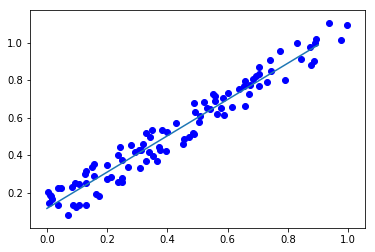

In [129]:
plot_fit(feature, target, slope, intercept).show()

### => regression using Normal Equation

In [21]:
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
print(theta_value)

[[-3.7185181e+01]
 [ 4.3633747e-01]
 [ 9.3952334e-03]
 [-1.0711310e-01]
 [ 6.4479220e-01]
 [-4.0338000e-06]
 [-3.7813708e-03]
 [-4.2348403e-01]
 [-4.3721911e-01]]


### => regression using Batch Gradient Descent

In [67]:
# Gradient Descent requires scaling the feature vectors first. 
# We could do this using TF, but let's just use Scikit-Learn for now.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

scaled_housing_df = pd.DataFrame(
    data= scaled_housing_data,
    columns = housing['feature_names'])
scaled_housing_df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827


In [96]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

#compute the gradients manually
gradients = 2./m * tf.matmul(tf.transpose(X), error)

training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
print("Best theta:")
print(best_theta)

('Epoch', 0, 'MSE =', 8.805304)
('Epoch', 100, 'MSE =', 0.56650996)
('Epoch', 200, 'MSE =', 0.5487523)
('Epoch', 300, 'MSE =', 0.5395938)
('Epoch', 400, 'MSE =', 0.5340457)
('Epoch', 500, 'MSE =', 0.53061575)
('Epoch', 600, 'MSE =', 0.52845377)
('Epoch', 700, 'MSE =', 0.5270666)
('Epoch', 800, 'MSE =', 0.5261626)
('Epoch', 900, 'MSE =', 0.5255663)
Best theta:
[[ 2.0685523e+00]
 [ 8.5735834e-01]
 [ 1.2673114e-01]
 [-3.1273839e-01]
 [ 3.4245053e-01]
 [-1.9602410e-03]
 [-4.0592730e-02]
 [-8.1566954e-01]
 [-7.8930187e-01]]


### => regression using Batch Gradient Descent & Autodiff

In [95]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

('Epoch', 0, 'MSE =', 9.161543)
('Epoch', 100, 'MSE =', 0.7145006)
('Epoch', 200, 'MSE =', 0.566705)
('Epoch', 300, 'MSE =', 0.5555719)
('Epoch', 400, 'MSE =', 0.5488112)
('Epoch', 500, 'MSE =', 0.5436362)
('Epoch', 600, 'MSE =', 0.5396294)
('Epoch', 700, 'MSE =', 0.5365092)
('Epoch', 800, 'MSE =', 0.5340678)
('Epoch', 900, 'MSE =', 0.5321474)
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


### => regression using Batch Gradient Descent & Autodiff & optimizer

In [ ]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

